## LLM Output Analysis
#### David da Costa Correia @ FCUL & INSA

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import ast
import json
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def load_duplicates(folder, common_name, k):
	log_files = [file for _,_,files in os.walk(folder) for file in files if common_name in file]
	log_files.sort()

	duplicates = defaultdict(list)
	for file in log_files[:k]:
		with open(os.path.join(folder,file), 'r') as f:
			entries = json.load(f)
		
		for entry in entries:
			if entry['model'] == 'gemma2:27b':
				continue
			index = (entry['model'], entry['n_shots'])
			info = {
				'precision': entry['metrics']['precision'],
				'recall': entry['metrics']['recall'],
				'f1': entry['metrics']['f1'],
				'invalid%': entry['invalid%'],
				'runtime': entry['runtime']['single'],
				'n_queries': entry['n_queries']
			}
			duplicates[index].append(info)

	return dict(duplicates)


def analyse_duplicates(duplicates):
	metrics = ['precision','recall','f1','invalid%','runtime','n_queries']
	
	results = defaultdict(list)
	models = []
	for model,infos in duplicates.items():
		models.append(model)
		for metric in metrics:
			values = [info[metric] for info in infos]
			results[metric].append(round(np.mean(values),4))
			results[metric+'_dev'].append(round(np.std(values),4))

	results = pd.DataFrame(results, index=models)
	return results

def plot_results(results_df, palette):
	data = {
		'Model':[idx[0] for idx in results_df.index],
		'Shots':[idx[1] for idx in results_df.index],
		'Queries':results_df['n_queries'].tolist(),
		'F1':results_df['f1'].tolist()
	}
	df = pd.DataFrame(data)

	plt.figure(figsize=(8, 5))

	sns.lineplot(data=df, x='Shots', y='F1', hue='Model', marker='o', legend=False, palette=palette, estimator=None)
	sns.scatterplot(data=df, x='Shots', y='F1', hue='Model', size='Queries', sizes=(20, 200), legend='brief', palette=palette, zorder=4)

	best = df.loc[df['F1'].idxmax()]
	best_label = f"Best:\nF1: {best['F1']:.3f}\nmodel: {best['Model']}\nn_shots: {best['Shots']}\nn_queries: {best['Queries']}"
	sns.scatterplot(data=pd.DataFrame([best]), x='Shots', y='F1', s=100, color='black', marker='+', label=best_label, zorder=5)

	# plt.title()
	plt.xticks([i for i in range(2,11,2)])
	plt.yticks([i*0.001 for i in range(800, 1001, 25)])
	plt.xlabel('Number of Examples')
	plt.ylabel('F1-Score')
	plt.grid(True)
	plt.legend(title='Model', bbox_to_anchor=(1.01, 1.02), loc='upper left')
	plt.tight_layout()
	plt.show()

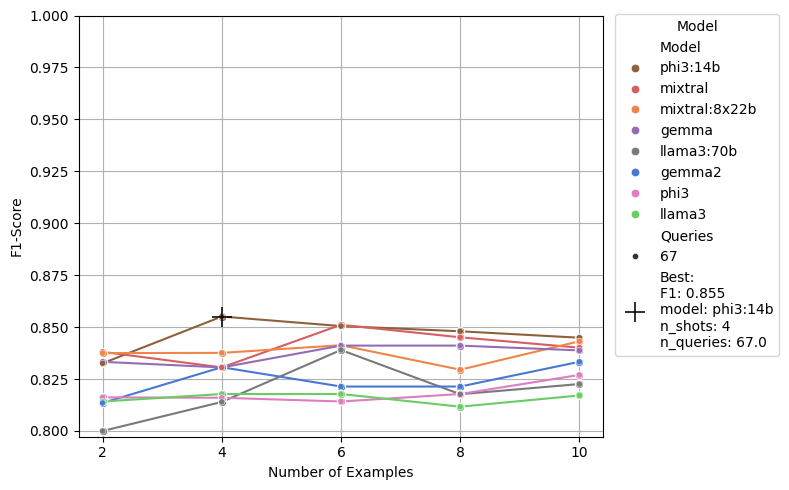

In [22]:
control = load_duplicates('./outputs/chained', 'control', 4)
control_results = analyse_duplicates(control).sort_values(by=['f1','invalid%'], ascending=False)

models = list(set([run[0] for run in control]))
palette = sns.color_palette("muted", n_colors=len(models))
palette = {models[i]:color for i,color in enumerate(palette)}
plot_results(control_results, palette)

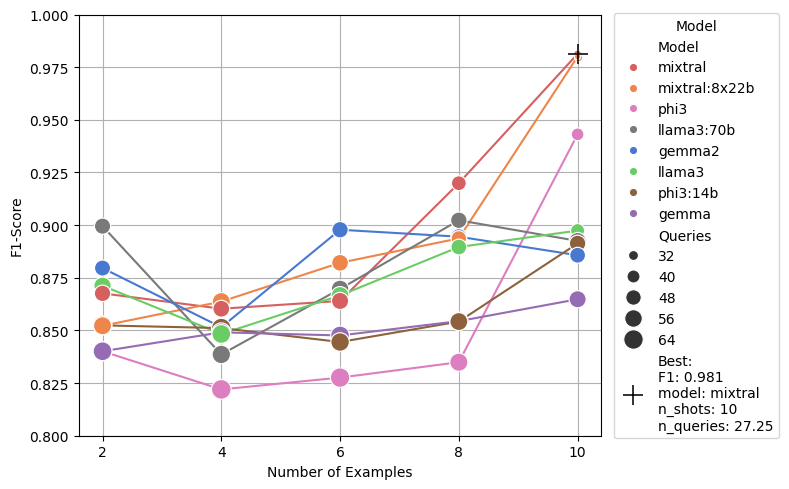

In [23]:
chained = load_duplicates('./outputs/chained', 'chained', 4)
chained_results = analyse_duplicates(chained).sort_values(by=['f1','invalid%'], ascending=False)
plot_results(chained_results, palette)

In [31]:
# def convert_to_json(old, new):
# 	with open(old, 'r') as f:
# 		raw_entries = f.read().split(f'\n\n{"="*100}\n')
	
# 	entries = []
# 	for raw_entry in raw_entries:
# 		if '> Model:' not in raw_entry: # badly formatted
# 			continue
		
# 		def read_field(field):
# 			try: return raw_entry.split(field)[1].split('\n')[0].strip()
# 			except: return None

# 		model = read_field('> Model:')
# 		n_shots = read_field('> N-shots:')
# 		options = read_field('> Options:')
# 		prompt = raw_entry.split("> Prompt:\n'''\n")[1].split("\n'''")[0]
# 		examples = raw_entry.split("> Examples:\n")[1].split("> Prediction time")[0].split('> > ')[1:]
# 		runtime = float(read_field('> Prediction time (average):').split(' s')[0])
# 		N = int(read_field('> Number of predictions:'))
# 		f1 = float(read_field('> > F1:'))
# 		prc = float(read_field('> > Precision:'))
# 		rcl = float(read_field('> > Recall:'))

# 		def read_mislabel(field):
# 			try: return ast.literal_eval(raw_entry.split(field)[1].split('): ')[1])
# 			except: return []

# 		fp = read_mislabel('> FP (')
# 		fn = read_mislabel('> FN (')
# 		inv = read_mislabel('> Invalid (')
# 		mislabels = {}
# 		for name,insts in zip(['fp','fn','invalid'],[fp,fn,inv]):
# 			n = len(insts)
# 			if n == 0: continue
# 			insts = [{'query':inst[0],'model_response':inst[1]} for inst in insts]
# 			mislabel = {'N':n, 'instances':insts}
# 			mislabels[name] = mislabel

# 		if len(mislabels) == 0:
# 			mislabels = None

# 		entry = {
# 			'model': model,
# 			'n_shots': n_shots,
# 			'options': options,
# 			'prompt': prompt,
# 			'examples': examples,
# 			'n_queries': N,
# 			'runtime': {'total': runtime, 'single': runtime/N},
# 			'invalid%': (len(inv)/N)*100,
# 			'metrics': {'precision': prc, 'recall': rcl, 'f1': f1},
# 			'mislabels': mislabels
# 		}
# 		entries.append(entry)
	
# 	with open(new, 'w') as f:
# 		json.dump(entries, f, indent=1)

# def convert_n_preds_to_invalid(log_file):
# 	with open(log_file, 'r') as f:
# 		raw_entries = json.load(f)
	
# 	entries = []
# 	for raw_entry in raw_entries:
# 		try:
# 			N_inv = raw_entry['mislabels']['inv']['N']
# 		except KeyError:
# 			N_inv = 0
# 		N = raw_entry['n_preds'] + N_inv
		
# 		if raw_entry['model'] != 'mixtral:8x22b':
# 			continue

# 		display(raw_entry)
# 		entry = {
# 			'model': raw_entry['model'],
# 			'n_shots': raw_entry['n_shots'],
# 			'options': raw_entry['options'],
# 			'prompt': raw_entry['prompt'],
# 			'examples': raw_entry['examples'],
# 			'n_queries': N,
# 			'runtime': raw_entry['runtime'],
# 			'invalid%': (N_inv/N)*100,
# 			'metrics': raw_entry['metrics'],
# 			'mislabels': raw_entry['mislabels']
# 		}
# 		display(entry)